<a href="https://colab.research.google.com/github/Hyon2-park/static/blob/master/%EC%98%88%EC%B8%A1%EB%AA%A8%EB%8D%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. 강수량 월단위 분할 후 모델링 1차
2. 데이터 log변환 후 예측 모델링
3. 최종 모델 : ExtraTree
4. r2 : 0.92
5. train : test = 8:2

In [ ]:
import pandas as pd

df = pd.read_csv("total_data_monthly.csv", encoding="utf-8-sig").dropna()

print(df.shape)
print(df.columns)
df_base = df[["지역명","연도","월","인구밀도","경사도_평균","이재민 인","건물피해액","월강수량",]].copy()

df_base = df_base.rename(
    columns={
        "경사도_평균": "경사도",
        "이재민 인": "이재민",
        "월강수량": "강수량",
    }
)

print(df_base.shape)
print(df_base.columns)
df_base

(6145, 12)
Index(['지역명', '연도', '인구밀도', '인구밀도_평균', '인구밀도_표준편차', '인구밀도_', '경사도_평균',
       '경사도_최대', '이재민 인', '건물피해액', '월', '월강수량'],
      dtype='object')
(6145, 8)
Index(['지역명', '연도', '월', '인구밀도', '경사도', '이재민', '건물피해액', '강수량'], dtype='object')


,지역명,연도,월,인구밀도,경사도,이재민,건물피해액,강수량
0,강원특별자치도 강릉시,2012,6.0,209.32,17.641871,23.0,7800.0,84.0
1,강원특별자치도 강릉시,2012,7.0,209.32,17.641871,23.0,7800.0,1049.8
2,강원특별자치도 강릉시,2012,8.0,209.32,17.641871,23.0,7800.0,1001.8
3,강원특별자치도 강릉시,2012,9.0,209.32,17.641871,23.0,7800.0,877.5
4,강원특별자치도 강릉시,2013,6.0,208.39,17.641871,0.0,0.0,114.6
...,...,...,...,...,...,...,...,...
6250,충청북도 충주시,2019,9.0,214.28,13.583274,3.0,21000.0,413.0
6251,충청북도 충주시,2020,6.0,213.69,13.583274,257.0,1119000.0,320.5
6252,충청북도 충주시,2020,7.0,213.69,13.583274,257.0,1119000.0,1172.0
6253,충청북도 충주시,2020,8.0,213.69,13.583274,257.0,1119000.0,1683.0


In [ ]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, KFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

1. 파생변수 포함 전

In [ ]:

# 데이터 분포 처리 log
df_base["인구밀도_log"] = np.log1p(df_base["인구밀도"])
df_base["강수량_log"] = np.log1p(df_base["강수량"])
df_base["건물피해액_log"] = np.log1p(df_base["건물피해액"])
df_base["강수대비경사"] = df_base["강수량_log"] * df_base["경사도"]
df_base["강수대비인구"] = df_base["강수량_log"] * df_base["인구밀도_log"]
df_base['이재민_log']=np.log1p(df_base['이재민'])

#타겟 변수 선정
features = ["인구밀도_log", "강수량_log", "건물피해액_log", "경사도"]

x = df_base[features]
y=df_base['이재민_log']

# 8:2분류
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=1
)

In [ ]:

# (선택) XGBoost 설치되어 있으면 사용
try:
    from xgboost import XGBRegressor
    has_xgb = True
except Exception:
    has_xgb = False


# -----------------------
# 0) scoring 정의
# -----------------------
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse_scorer = make_scorer(rmse, greater_is_better=False)  # cross_validate는 클수록 좋다고 가정하므로 -RMSE


# -----------------------
# 1) 모델 파이프라인 모음
#    - 스케일 민감: scaler 포함
#    - 트리계열: scaler 생략
# -----------------------
pipelines = {
    # 선형
    "Linear": Pipeline([("model", LinearRegression())]),
    "Ridge": Pipeline([("scaler", StandardScaler()),
                       ("model", Ridge(alpha=1.0, random_state=42))]),
    "Lasso": Pipeline([("scaler", StandardScaler()),
                       ("model", Lasso(alpha=0.001, random_state=42))]),
    "ElasticNet": Pipeline([("scaler", StandardScaler()),
                            ("model", ElasticNet(alpha=0.001, l1_ratio=0.5, random_state=42))]),

    # 거리/커널
    "KNN": Pipeline([("scaler", StandardScaler()),
                     ("model", KNeighborsRegressor(n_neighbors=10))]),
    "SVR(RBF)": Pipeline([("scaler", StandardScaler()),
                          ("model", SVR(C=10, gamma="scale", epsilon=0.1))]),

    # 트리/부스팅
    "RandomForest": Pipeline([("model", RandomForestRegressor(
        n_estimators=800, random_state=42, n_jobs=-1
    ))]),
    "ExtraTrees": Pipeline([("model", ExtraTreesRegressor(
        n_estimators=1200, random_state=42, n_jobs=-1, min_samples_leaf=2
    ))]),
    "GBR": Pipeline([("model", GradientBoostingRegressor(random_state=42))]),
    "HistGBR": Pipeline([("model", HistGradientBoostingRegressor(random_state=42))]),
}

if has_xgb:
    pipelines["XGBoost"] = Pipeline([("model", XGBRegressor(
        n_estimators=1200,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.9,
        colsample_bytree=0.9,
        random_state=42,
        n_jobs=-1
    ))])


# -----------------------
# 2) Train 내부 5-Fold CV로 모델 비교/선정
# -----------------------
cv = KFold(n_splits=5, shuffle=True, random_state=42)

rows = []
cv_cache = {}  # 나중에 best 모델 확인용

for name, pipe in pipelines.items():
    scores = cross_validate(
        pipe, x_train, y_train,
        cv=cv,
        scoring={
            "rmse": rmse_scorer,
            "mae": make_scorer(mean_absolute_error, greater_is_better=False),
            "r2": "r2"
        },
        n_jobs=-1,
        return_train_score=False
    )
    cv_cache[name] = scores

    rows.append({
        "model": name,
        "CV_RMSE_mean": -scores["test_rmse"].mean(),
        "CV_RMSE_std":  scores["test_rmse"].std(),
        "CV_MAE_mean":  -scores["test_mae"].mean(),
        "CV_R2_mean":   scores["test_r2"].mean()
    })

cv_result = pd.DataFrame(rows).sort_values("CV_RMSE_mean")
print("\n===== 5-Fold CV 결과 (Train 내부) =====")
print(cv_result)

best_model_name = cv_result.iloc[0]["model"]
best_pipe = pipelines[best_model_name]

print("\n✅ Best model by CV_RMSE:", best_model_name)


# -----------------------
# 3) 최종: Best 모델을 Train 전체로 학습 → Test 평가
# -----------------------
best_pipe.fit(x_train, y_train)
pred_test = best_pipe.predict(x_test)

test_rmse = rmse(y_test, pred_test)
test_mae  = mean_absolute_error(y_test, pred_test)
test_r2   = r2_score(y_test, pred_test)

print("\n===== 최종 Test 성능 =====")
print("Best model:", best_model_name)
print("RMSE:", test_rmse)
print("MAE :", test_mae)
print("R2  :", test_r2)


# -----------------------
# (선택) log 타깃이면 원단위 성능도 같이 보기
# y_train/y_test가 log1p(이재민)일 때 의미 있음
# -----------------------
pred_real = np.expm1(pred_test)
true_real = np.expm1(y_test)

pred_real = np.clip(pred_real, 0, None)

real_rmse = rmse(true_real, pred_real)
real_mae  = mean_absolute_error(true_real, pred_real)
real_r2   = r2_score(true_real, pred_real)

print("\n===== 원단위(Real scale) Test 성능 (y가 log1p일 때) =====")
print("RMSE_real:", real_rmse)
print("MAE_real :", real_mae)
print("R2_real  :", real_r2)



===== 5-Fold CV 결과 (Train 내부) =====
          model  CV_RMSE_mean  CV_RMSE_std  CV_MAE_mean  CV_R2_mean
7    ExtraTrees      0.541877     0.062834     0.248922    0.896746
6  RandomForest      0.585267     0.061487     0.275857    0.879566
9       HistGBR      0.709895     0.075822     0.389962    0.823549
8           GBR      0.868632     0.054758     0.507037    0.737708
5      SVR(RBF)      1.033518     0.079632     0.562243    0.628497
4           KNN      1.052531     0.078212     0.596322    0.615092
2         Lasso      1.204893     0.048855     0.803442    0.496891
3    ElasticNet      1.204898     0.048863     0.803574    0.496887
1         Ridge      1.204914     0.048845     0.803903    0.496871
0        Linear      1.204915     0.048838     0.803969    0.496869

✅ Best model by CV_RMSE: ExtraTrees

===== 최종 Test 성능 =====
Best model: ExtraTrees
RMSE: 0.435081910587111
MAE : 0.194950099770426
R2  : 0.9401316189033839

===== 원단위(Real scale) Test 성능 (y가 log1p일 때) =====
RMSE_re

 y변수와 상관계수가 높은 변수들만 선정해 모델링 진행
 - 경사도 / 인구밀도 log 제외

In [ ]:
columns=df_base[["강수량_log", "건물피해액_log","강수대비경사","강수대비인구","이재민_log"]]
y=columns['이재민_log']
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=1
)

c:\Users\hyoeu\AppData\Local\Programs\Python\Python313\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Malgun Gothic.
  fig.canvas.draw()
c:\Users\hyoeu\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Malgun Gothic.
  fig.canvas.print_figure(bytes_io, **kw)


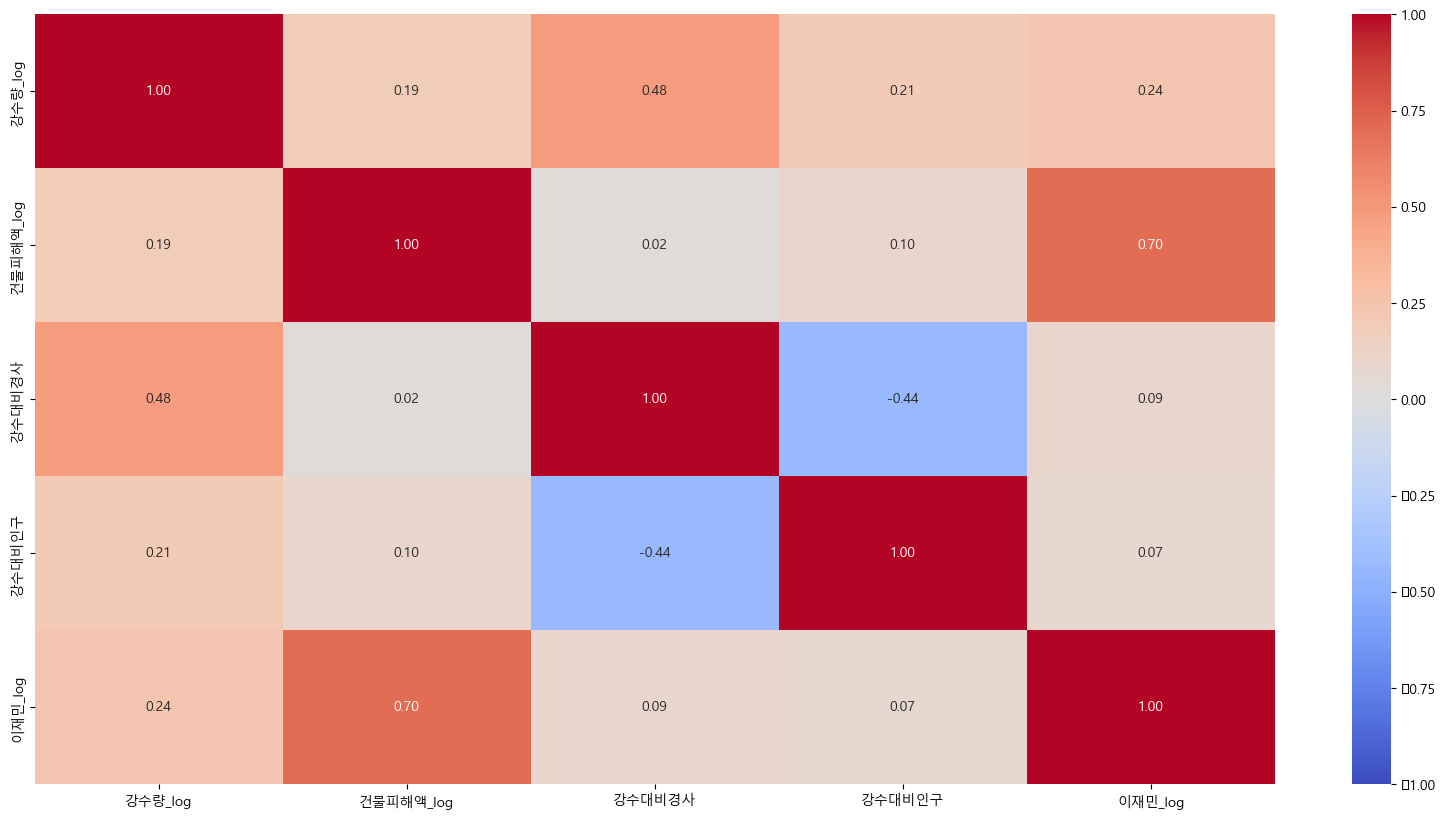

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 나눔고딕 폰트 경로 설정 (Windows 예시)
font_path = 'C:/Windows/Fonts/malgun.ttf'
font_name = fm.FontProperties(fname=font_path).get_name()
plt.rc('font', family=font_name)



corr=columns.corr(numeric_only=True)
plt.figure(figsize=(20, 10)) # 그래프 크기 설정
sns.heatmap(corr,
            annot=True,      # 숫자 표시
            fmt=".2f",       # 소수점 자리수
            cmap='coolwarm', # 색상 조합
            vmin=-1, vmax=1) # 상관계수 범위 (-1 ~ 1)
plt.show()

In [ ]:

# (선택) XGBoost 설치되어 있으면 사용
try:
    from xgboost import XGBRegressor
    has_xgb = True
except Exception:
    has_xgb = False


# -----------------------
# 0) scoring 정의
# -----------------------
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse_scorer = make_scorer(rmse, greater_is_better=False)  # cross_validate는 클수록 좋다고 가정하므로 -RMSE


# -----------------------
# 1) 모델 파이프라인 모음
#    - 스케일 민감: scaler 포함
#    - 트리계열: scaler 생략
# -----------------------
pipelines = {
    # 선형
    "Linear": Pipeline([("model", LinearRegression())]),
    "Ridge": Pipeline([("scaler", StandardScaler()),
                       ("model", Ridge(alpha=1.0, random_state=42))]),
    "Lasso": Pipeline([("scaler", StandardScaler()),
                       ("model", Lasso(alpha=0.001, random_state=42))]),
    "ElasticNet": Pipeline([("scaler", StandardScaler()),
                            ("model", ElasticNet(alpha=0.001, l1_ratio=0.5, random_state=42))]),

    # 거리/커널
    "KNN": Pipeline([("scaler", StandardScaler()),
                     ("model", KNeighborsRegressor(n_neighbors=10))]),
    "SVR(RBF)": Pipeline([("scaler", StandardScaler()),
                          ("model", SVR(C=10, gamma="scale", epsilon=0.1))]),

    # 트리/부스팅
    "RandomForest": Pipeline([("model", RandomForestRegressor(
        n_estimators=800, random_state=42, n_jobs=-1
    ))]),
    "ExtraTrees": Pipeline([("model", ExtraTreesRegressor(
        n_estimators=1200, random_state=42, n_jobs=-1, min_samples_leaf=2
    ))]),
    "GBR": Pipeline([("model", GradientBoostingRegressor(random_state=42))]),
    "HistGBR": Pipeline([("model", HistGradientBoostingRegressor(random_state=42))]),
}

if has_xgb:
    pipelines["XGBoost"] = Pipeline([("model", XGBRegressor(
        n_estimators=1200,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.9,
        colsample_bytree=0.9,
        random_state=42,
        n_jobs=-1
    ))])


# -----------------------
# 2) Train 내부 5-Fold CV로 모델 비교/선정
# -----------------------
cv = KFold(n_splits=5, shuffle=True, random_state=42)

rows = []
cv_cache = {}  # 나중에 best 모델 확인용

for name, pipe in pipelines.items():
    scores = cross_validate(
        pipe, x_train, y_train,
        cv=cv,
        scoring={
            "rmse": rmse_scorer,
            "mae": make_scorer(mean_absolute_error, greater_is_better=False),
            "r2": "r2"
        },
        n_jobs=-1,
        return_train_score=False
    )
    cv_cache[name] = scores

    rows.append({
        "model": name,
        "CV_RMSE_mean": -scores["test_rmse"].mean(),
        "CV_RMSE_std":  scores["test_rmse"].std(),
        "CV_MAE_mean":  -scores["test_mae"].mean(),
        "CV_R2_mean":   scores["test_r2"].mean()
    })

cv_result = pd.DataFrame(rows).sort_values("CV_RMSE_mean")
print("\n===== 5-Fold CV 결과 (Train 내부) =====")
print(cv_result)

best_model_name = cv_result.iloc[0]["model"]
best_pipe = pipelines[best_model_name]

print("\n✅ Best model by CV_RMSE:", best_model_name)


# -----------------------
# 3) 최종: Best 모델을 Train 전체로 학습 → Test 평가
# -----------------------
best_pipe.fit(x_train, y_train)
pred_test = best_pipe.predict(x_test)

test_rmse = rmse(y_test, pred_test)
test_mae  = mean_absolute_error(y_test, pred_test)
test_r2   = r2_score(y_test, pred_test)

print("\n===== 최종 Test 성능 =====")
print("Best model:", best_model_name)
print("RMSE:", test_rmse)
print("MAE :", test_mae)
print("R2  :", test_r2)


# -----------------------
# y_train/y_test가 log1p(이재민)일 때 의미 있음
# -----------------------
pred_real = np.expm1(pred_test)
true_real = np.expm1(y_test)

pred_real = np.clip(pred_real, 0, None)

real_rmse = rmse(true_real, pred_real)
real_mae  = mean_absolute_error(true_real, pred_real)
real_r2   = r2_score(true_real, pred_real)

print("\n===== 원단위(Real scale) Test 성능 (y가 log1p일 때) =====")
print("RMSE_real:", real_rmse)
print("MAE_real :", real_mae)
print("R2_real  :", real_r2)



===== 5-Fold CV 결과 (Train 내부) =====
          model  CV_RMSE_mean  CV_RMSE_std  CV_MAE_mean  CV_R2_mean
7    ExtraTrees      0.623888     0.065824     0.304244    0.863405
6  RandomForest      0.660359     0.065995     0.326824    0.847086
9       HistGBR      0.755727     0.070079     0.413943    0.800381
8           GBR      0.870977     0.056870     0.508359    0.736269
5      SVR(RBF)      1.041271     0.083161     0.570084    0.623052
4           KNN      1.086544     0.085478     0.616819    0.590087
2         Lasso      1.205179     0.048695     0.803688    0.496642
3    ElasticNet      1.205307     0.048684     0.803959    0.496529
1         Ridge      1.205429     0.048647     0.804376    0.496409
0        Linear      1.205459     0.048638     0.804469    0.496380

✅ Best model by CV_RMSE: ExtraTrees

===== 최종 Test 성능 =====
Best model: ExtraTrees
RMSE: 0.5648729816782967
MAE : 0.2623432028676711
R2  : 0.8990846883587265

===== 원단위(Real scale) Test 성능 (y가 log1p일 때) =====
RMSE_

최종적으로 ExtraTreeRegressor 모델이 r2 0.84로 가장 높은 성능을 보였음
실제 값과 절대값 차이(MAE)는 약 12명 정도임.
파생변수를 생성하지 않고 인구밀도와 경사도를 그대로 사용했을 경우 0.91로 높은 성능을 보이긴 했으나 연도별 강수/이재민 수를 고려하지 못하였으며 과적합 오류가 예상됨.